In [22]:
# https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
# http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html

In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

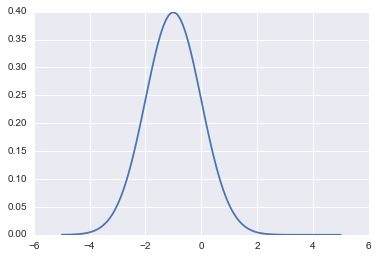

In [2]:
mu = -1
sigma = 1
xs = np.linspace(-5, 5, 100)
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

In [3]:
TRAIN_ITERS = 10000
BATCH_SIZE = 200

In [4]:

# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [8]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer   

# pre-trian decision surface 

In [6]:
with tf.variable_scope('D_pre'):
    input_node = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, 1))
    D, theta = mlp(input_node, 1)
    loss = tf.reduce_mean(tf.square(D - train_labels))
    

In [10]:
optimzier = momentum_optimizer(loss, None)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [20]:
#  plot decision surface
def plot_d0(D, input_node):
    f, ax = plt.subplots(1)
    #p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    # decision boundary
    r = 1000
    xs = np.linspace(-5, 5, r)
    ds = np.zeros((r, 1)) #ds = decision surface
    for i in range(r//BATCH_SIZE):
        x = np.reshape(xs[BATCH_SIZE*i:BATCH_SIZE*(i+1)], (BATCH_SIZE, 1))
        ds[BATCH_SIZE*i:BATCH_SIZE*(i+1)] = sess.run(D, {input_node: x})
    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0, 1.1)
    plt.legend()
    
    

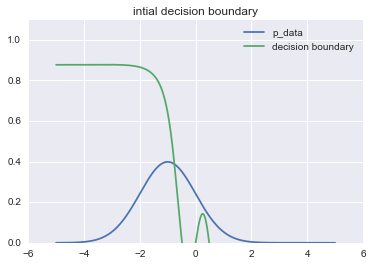

In [21]:
plot_d0(D, input_node)
plt.title('intial decision boundary')